In [1]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Define base directory
BASE_DIR = "/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 11

# Load dataset
def load_data(base_dir):
    images, labels = [], []
    
    for label, class_name in enumerate(["benign", "malignant"]):
        class_dir = os.path.join(base_dir, class_name, "SOB")
        for subtype in os.listdir(class_dir):
            subtype_dir = os.path.join(class_dir, subtype)
            for patient in os.listdir(subtype_dir):
                patient_dir = os.path.join(subtype_dir, patient)
                for mag in ["40X", "100X", "200X", "400X"]:
                    mag_dir = os.path.join(patient_dir, mag)
                    if os.path.exists(mag_dir):
                        for img_file in os.listdir(mag_dir):
                            if img_file.endswith(".png"):
                                img_path = os.path.join(mag_dir, img_file)
                                img = cv2.imread(img_path)
                                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                                images.append(img)
                                labels.append(label)
    
    return np.array(images) / 255.0, np.array(labels)

# Load data
X, y = load_data(BASE_DIR)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.2)
datagen.fit(X_train)

In [2]:
SAVE_DIR = "/kaggle/working/"

In [3]:

# Function to save history
def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

# Function to plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(os.path.join(SAVE_DIR, f"{model_name}_training_plot.png"))
    plt.show()

# Function to train model
def train_model(model, name, X_train, y_train, X_val, y_val, X_test, y_test):
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        validation_data=datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                        epochs=EPOCHS)
    test_loss, test_acc = model.evaluate(datagen.flow(X_test, y_test, batch_size=BATCH_SIZE))
    print(f"{name} Test Accuracy: {test_acc}")
    
    # Save model, history, and test accuracy
    model.save(os.path.join(SAVE_DIR, f"{name}.h5"))
    save_history(history, os.path.join(SAVE_DIR, f"{name}_history.json"))
    with open(os.path.join(SAVE_DIR, f"{name}_test_acc.txt"), "w") as f:
        f.write(str(test_acc))
    
    plot_history(history, name)
    return model, history, test_acc

# Define models
def build_resnet():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

def build_vgg():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    return model

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.6537 - loss: 0.6598 - val_accuracy: 0.6863 - val_loss: 0.6279
Epoch 2/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - accuracy: 0.6768 - loss: 0.6295 - val_accuracy: 0.6863 - val_loss: 0.6142
Epoch 3/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 91ms/step - accuracy: 0.6854 - loss: 0.6179 - val_accuracy: 0.6863 - val_loss: 0.6099
Epoch 4/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.6756 - loss: 0.6248 - val_accuracy: 0.6863 - val_loss: 0.6081
Epoch 5/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.6961 - loss: 0.6096 - val_accuracy: 0.6863 - val_loss: 0.6091
Epoch 6/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.6867 - loss: 0.6142 - val_accuracy: 0.6863 - val_loss: 0.6560
Epoch 7/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 91ms/step - accuracy: 0.6783 - loss: 0.6167 - val_accuracy: 0.6863 - val_loss: 0.6108
Epoch 8/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - accuracy: 0.6904 - loss: 0.6122 - val_accura

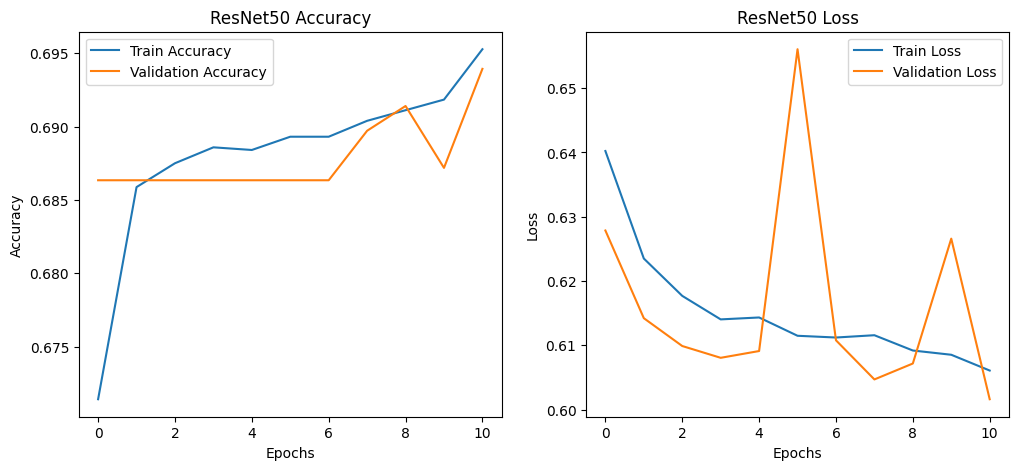

In [4]:
import gc
tf.keras.backend.clear_session()
gc.collect()

# Train ResNet50
tf.keras.backend.clear_session()
resnet_model = build_resnet()
resnet_model, resnet_history, resnet_test_acc = train_model(resnet_model, "ResNet50", X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


692/692 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.7124 - loss: 0.5639 - val_accuracy: 0.7841 - val_loss: 0.4718
Epoch 2/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - accuracy: 0.7910 - loss: 0.4538 - val_accuracy: 0.8111 - val_loss: 0.4156
Epoch 3/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 91ms/step - accuracy: 0.8098 - loss: 0.4265 - val_accuracy: 0.8229 - val_loss: 0.4113
Epoch 4/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.8288 - loss: 0.3906 - val_accuracy: 0.7960 - val_loss: 0.4243
Epoch 5/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.8341 - loss: 0.3818 - val_accuracy: 0.8398 - val_loss: 0.3803
Epoch 6/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.8307 - loss: 0.3834 - val_accuracy: 0.8390 - val_loss: 0.3765
Epoch 7/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.8467 - loss: 0.3596 - val_accuracy: 0.8288 - val_loss: 0.4027
Epoch 8/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.8389 - loss: 0.3634 - val_accurac

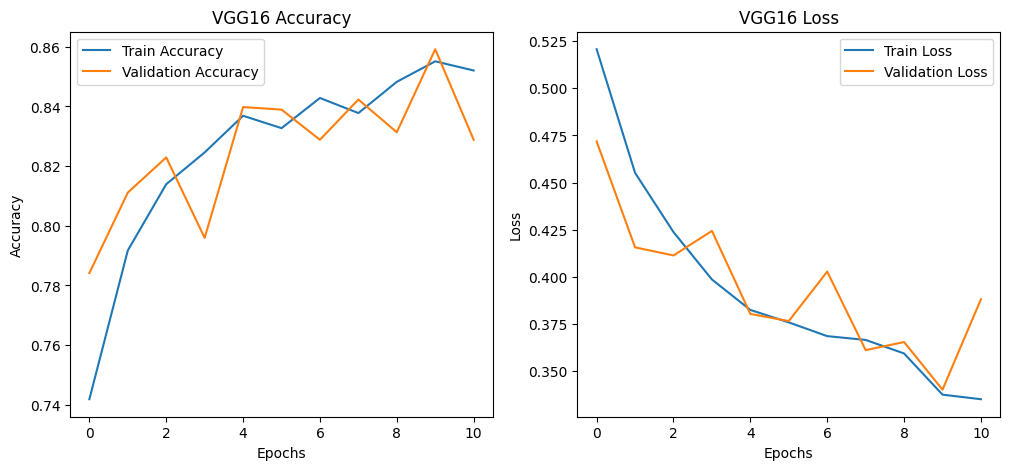

In [4]:
import gc
tf.keras.backend.clear_session()
gc.collect()

# Train VGG16
tf.keras.backend.clear_session()
vgg_model = build_vgg()
vgg_model, vgg_history, vgg_test_acc = train_model(vgg_model, "VGG16", X_train, y_train, X_val, y_val, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


692/692 ━━━━━━━━━━━━━━━━━━━━ 69s 91ms/step - accuracy: 0.7118 - loss: 0.6507 - val_accuracy: 0.7631 - val_loss: 0.5348
Epoch 2/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.8011 - loss: 0.4722 - val_accuracy: 0.7336 - val_loss: 0.6268
Epoch 3/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.8192 - loss: 0.4496 - val_accuracy: 0.8381 - val_loss: 0.4182
Epoch 4/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.8272 - loss: 0.4322 - val_accuracy: 0.8103 - val_loss: 0.4686
Epoch 5/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.8171 - loss: 0.4374 - val_accuracy: 0.8331 - val_loss: 0.4112
Epoch 6/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.8264 - loss: 0.4253 - val_accuracy: 0.8600 - val_loss: 0.3795
Epoch 7/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.8405 - loss: 0.4143 - val_accuracy: 0.8558 - val_loss: 0.3926
Epoch 8/11
692/692 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.8520 - loss: 0.3928 - val_accurac

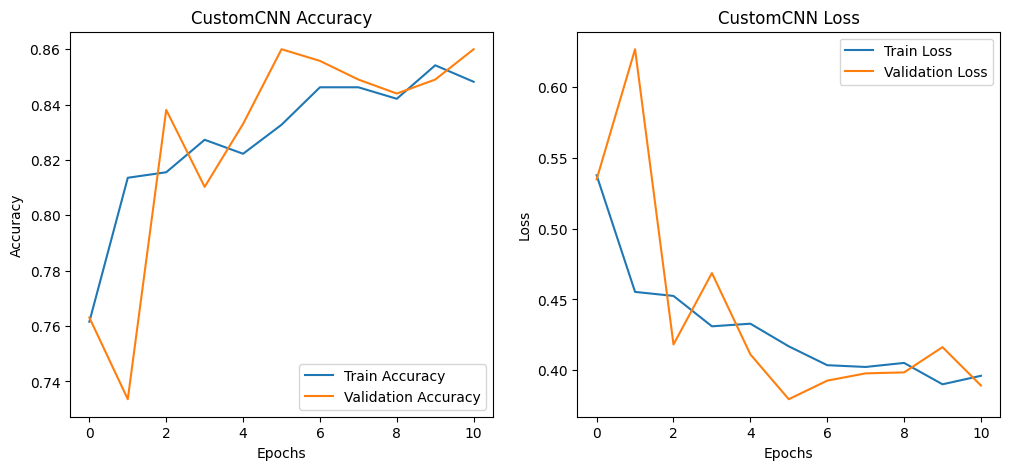

In [4]:
import gc
tf.keras.backend.clear_session()
gc.collect()

# Train Custom CNN
tf.keras.backend.clear_session()
custom_model = build_custom_cnn()
custom_model, custom_history, custom_test_acc = train_model(custom_model, "CustomCNN", X_train, y_train, X_val, y_val, X_test, y_test)

In [6]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split


BASE_DIR = "/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
def load_data(base_dir):
    images, labels = [], []
    
    for label, class_name in enumerate(["benign", "malignant"]):
        class_dir = os.path.join(base_dir, class_name, "SOB")
        for subtype in os.listdir(class_dir):
            subtype_dir = os.path.join(class_dir, subtype)
            for patient in os.listdir(subtype_dir):
                patient_dir = os.path.join(subtype_dir, patient)
                for mag in ["40X", "100X", "200X", "400X"]:
                    mag_dir = os.path.join(patient_dir, mag)
                    if os.path.exists(mag_dir):
                        for img_file in os.listdir(mag_dir):
                            if img_file.endswith(".png"):
                                images.append(os.path.join(mag_dir, img_file))
                                labels.append(label)
    
    return images, labels

# Load data
image_paths, labels = load_data(BASE_DIR)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [7]:
# Define dataset class
class BreakHisDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Create DataLoaders
datasets = {
    "train": BreakHisDataset(X_train, y_train, transform),
    "val": BreakHisDataset(X_val, y_val, transform),
    "test": BreakHisDataset(X_test, y_test, transform)
}

dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True),
    "val": DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False),
    "test": DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False)
}

# Load pre-trained MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = torch.nn.Linear(mobilenet.classifier[1].in_features, 2)
mobilenet.to(device)
optimizer = torch.optim.AdamW(mobilenet.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


In [65]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss, correct_preds = 0.0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * labels.size(0)
                correct_preds += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = correct_preds.double() / len(datasets[phase])
            
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.cpu().numpy())
            
            print(f"Epoch {epoch+1}/{num_epochs}, {phase} Loss: {epoch_loss:.4f}, {phase} Acc: {epoch_acc:.4f}")
    
    return model, history

# Train MobileNetV2 model
mobilenet, mobilenet_history = train_model(mobilenet, dataloaders, criterion, optimizer, num_epochs=EPOCHS)



Epoch 1/5, train Loss: 0.0722, train Acc: 0.9733
Epoch 1/5, val Loss: 0.1407, val Acc: 0.9545
Epoch 2/5, train Loss: 0.0762, train Acc: 0.9706
Epoch 2/5, val Loss: 0.1217, val Acc: 0.9578
Epoch 3/5, train Loss: 0.0782, train Acc: 0.9689
Epoch 3/5, val Loss: 0.1355, val Acc: 0.9469
Epoch 4/5, train Loss: 0.0862, train Acc: 0.9731
Epoch 4/5, val Loss: 0.1339, val Acc: 0.9528
Epoch 5/5, train Loss: 0.0728, train Acc: 0.9731
Epoch 5/5, val Loss: 0.1263, val Acc: 0.9511


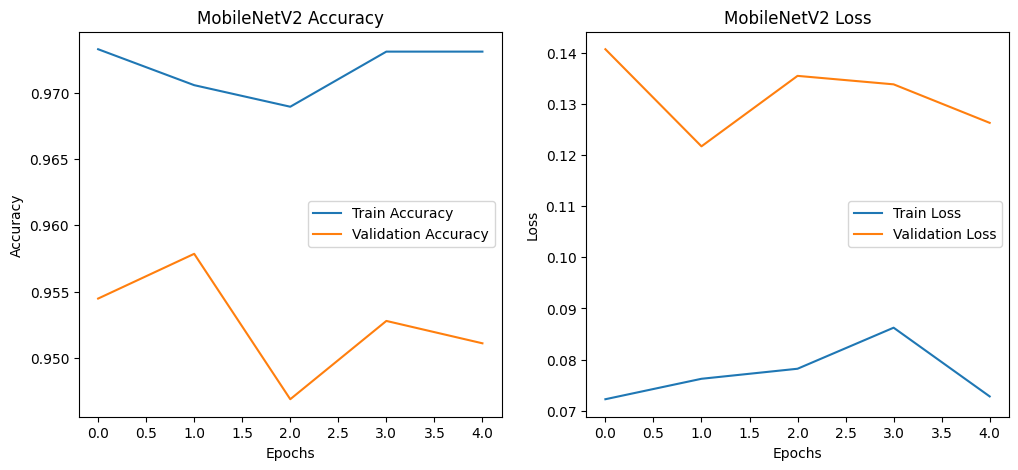

In [66]:
# Save model and history
torch.save(mobilenet.state_dict(), os.path.join(SAVE_DIR, "MobileNetV2_model.pth"))
# Convert NumPy arrays to lists for JSON serialization
for key in mobilenet_history:
    mobilenet_history[key] = list(map(float, mobilenet_history[key]))  

# Save training history
with open(os.path.join(SAVE_DIR, "MobileNetV2_history.json"), "w") as f:
    json.dump(mobilenet_history, f)


def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.savefig(os.path.join(SAVE_DIR, f"{model_name}_training_plot.png"))
    plt.show()

plot_history(mobilenet_history, "MobileNetV2")

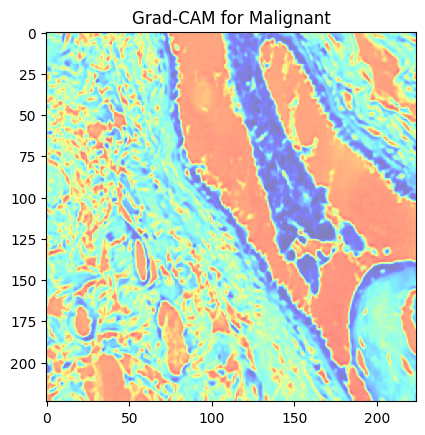

ValueError: masker cannot be None.

In [67]:
# Implement Grad-CAM
def grad_cam(model, image, label):
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    
    output = model(image).logits
    class_idx = torch.argmax(output).item()
    
    model.zero_grad()
    output[0, class_idx].backward()
    gradients = image.grad
    weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
    activation_map = weights * image
    heatmap = torch.mean(activation_map, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)
    
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM for {['Benign', 'Malignant'][class_idx]}")
    plt.show()

# Apply Grad-CAM to a sample
sample_image, sample_label = dataset_test[0]
grad_cam(model, sample_image, sample_label)


  0%|          | 0/498 [00:00<?, ?it/s]

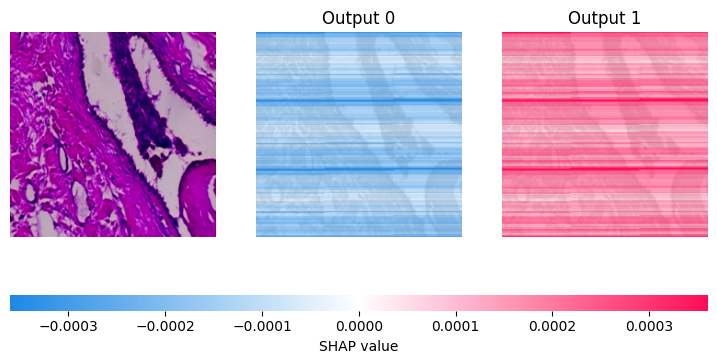

In [68]:
import numpy as np
import shap
import torch

# Convert image to NumPy and ensure correct format
sample_image, _ = dataset_test[0]
image_np = sample_image.numpy()  # Convert PyTorch tensor to NumPy
image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension -> (1, C, H, W)

# Define a wrapper function to ensure correct input shape for SHAP
def model_wrapper(x):
    x = torch.tensor(x, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
    return model(x).logits.detach().cpu().numpy()

# Create SHAP masker and explainer
masker = shap.maskers.Image("blur(10,10)", image_np.shape[1:])
explainer = shap.Explainer(model_wrapper, masker)

# Get SHAP values
shap_values = explainer(image_np.transpose(0, 2, 3, 1))  # Convert (B, C, H, W) -> (B, H, W, C)

# Plot SHAP results
shap.image_plot(shap_values)

In [44]:
import os
import json
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Define base directory
BASE_DIR = "/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
IMG_SIZE = 224
BATCH_SIZE = 8
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
#Load dataset
def load_data(base_dir):
    images, labels = [], []
    
    for label, class_name in enumerate(["benign", "malignant"]):
        class_dir = os.path.join(base_dir, class_name, "SOB")
        for subtype in os.listdir(class_dir):
            subtype_dir = os.path.join(class_dir, subtype)
            for patient in os.listdir(subtype_dir):
                patient_dir = os.path.join(subtype_dir, patient)
                for mag in ["40X", "100X", "200X", "400X"]:
                    mag_dir = os.path.join(patient_dir, mag)
                    if os.path.exists(mag_dir):
                        for img_file in os.listdir(mag_dir):
                            if img_file.endswith(".png"):
                                images.append(os.path.join(mag_dir, img_file))
                                labels.append(label)
    
    return images, labels

# Load data
image_paths, labels = load_data(BASE_DIR)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Define dataset class
class BreakHisDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


In [48]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create DataLoaders
dataset_train = BreakHisDataset(X_train, y_train, transform)
dataset_test = BreakHisDataset(X_test, y_test, transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Load ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Train model
num_epochs = 5
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    
    acc = correct / len(dataset_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_vit_model.pth"))

Epoch 1/5, Loss: 138.9092, Accuracy: 0.9279
Epoch 2/5, Loss: 36.5510, Accuracy: 0.9825
Epoch 3/5, Loss: 30.8724, Accuracy: 0.9859
Epoch 4/5, Loss: 19.7828, Accuracy: 0.9910
Epoch 5/5, Loss: 17.4843, Accuracy: 0.9926


In [50]:

# Load best model
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_vit_model.pth")))
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [57]:
def vit_attention_map(model, image):
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image, output_attentions=True)

    if outputs.attentions is None:
        print("No attention maps returned!")
        return

    print(f"Number of attention layers: {len(outputs.attentions)}")  # Debug
    attn_maps = outputs.attentions[-1]  # Get last layer attention
    print(f"Attention map shape: {attn_maps.shape}")  # Should be (batch, heads, seq, seq)

    attn_maps = attn_maps.mean(dim=1).squeeze(0).cpu().numpy()  # Average over heads
    print(f"Attention map after averaging heads: {attn_maps.shape}")

    cls_attn = attn_maps[0, 1:]  # Ignore CLS token self-attention
    num_patches = int((IMG_SIZE / 16) ** 2)  # Patch embedding size (224x224 -> 14x14 patches)
    
    if cls_attn.shape[0] != num_patches:
        print(f"Unexpected shape: {cls_attn.shape}, expected {num_patches}")
        return

    cls_attn = cls_attn.reshape(int(IMG_SIZE / 16), int(IMG_SIZE / 16))  # Reshape into 2D

    # Resize to match original image size
    cls_attn_resized = cv2.resize(cls_attn, (IMG_SIZE, IMG_SIZE))

    plt.imshow(cls_attn_resized, cmap="jet", alpha=0.6)
    plt.colorbar()
    plt.title("ViT Attention Map")
    plt.show()



`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of attention layers: 12
Attention map shape: torch.Size([1, 12, 197, 197])
Attention map after averaging heads: (197, 197)


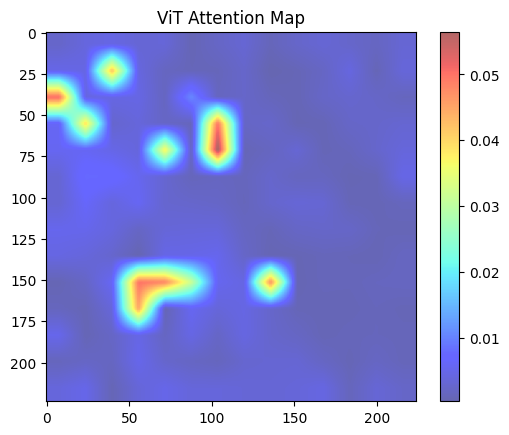

In [58]:
sample_image, _ = dataset_test[0]
vit_attention_map(model, sample_image)

  0%|          | 0/498 [00:00<?, ?it/s]

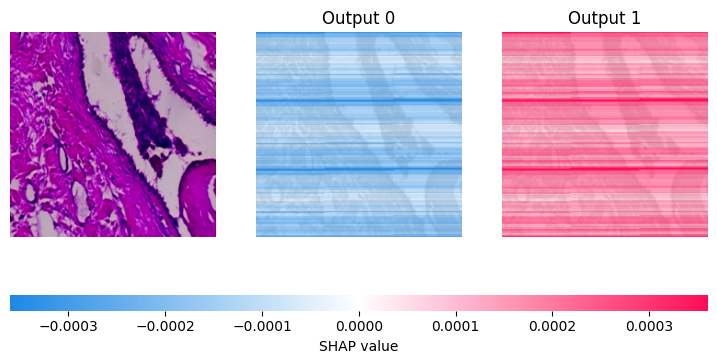

In [63]:
import numpy as np
import shap
import torch

# Convert image to NumPy and ensure correct format
sample_image, _ = dataset_test[0]
image_np = sample_image.numpy()  # Convert PyTorch tensor to NumPy
image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension -> (1, C, H, W)

# Define a wrapper function to ensure correct input shape for SHAP
def model_wrapper(x):
    x = torch.tensor(x, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
    return model(x).logits.detach().cpu().numpy()

# Create SHAP masker and explainer
masker = shap.maskers.Image("blur(10,10)", image_np.shape[1:])
explainer = shap.Explainer(model_wrapper, masker)

# Get SHAP values
shap_values = explainer(image_np.transpose(0, 2, 3, 1))  # Convert (B, C, H, W) -> (B, H, W, C)

# Plot SHAP results
shap.image_plot(shap_values)


In [64]:
# Save SHAP results
np.save(os.path.join(SAVE_DIR, "shap_values.npy"), shap_values.values)